In [1]:
import copy
import os

import matplotlib.pyplot as plt
import numpy as np

if "have_changed_cwd" not in globals():
    PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
    os.chdir(PROJECT_ROOT)
    have_changed_cwd = True
print(f"Working directory: {os.getcwd()}")

Working directory: /Users/mat/Desktop/Files/Code/Hopfield


In [2]:
from src.learning.classifier import HopfieldClassifier
from src.multi_net.logging import EnsembleLogger
from src.multi_net.plotting import ReplicatedPlotter, plot_couplings_histogram
from src.network.ensemble import HopfieldEnsemble
from src.network.initializer import (
    AsymmetricCoupling,
    SymmetricCoupling,
    binary_spin_state_sampler,
)
from src.network.logging import HopfieldLogger
from src.network.network import HopfieldNetwork

In [51]:
# Hyperparameters

# Network
N = 1000
y = 5
k = 1.6
J_D = 0.3
chained = True
symmetric = False
h = 3.2

# state and coupling initialization
state_initializer = binary_spin_state_sampler
coupling_initializer = (
    SymmetricCoupling(mean=0.0, std=1.0)
    if symmetric
    else AsymmetricCoupling(mean=0.0, std=1.0)
)

# simulation
log_interval = 1000
check_convergence_interval = 1000
seed = None
rng = np.random.default_rng(seed)
max_steps = 1_000_000

# data
C = 2  # number of classes
targets = [np.sign(np.random.randn(N)).astype(int) for _ in range(C)]

In [52]:
def initialize_classifier(
    N,
    coupling_initializer,
    state_initializer,
    J_D,
    y,
    k,
    chained,
    h,
    log_interval,
    check_convergence_interval,
    rng,
):
    networks = [
        HopfieldNetwork(
            N=N,
            coupling_initializer=coupling_initializer,
            state_initializer=state_initializer,
            J_D=J_D,
            rng=rng,
        )
        for _ in range(y)
    ]
    loggers = [HopfieldLogger(reference_state=net.state) for net in networks]
    similarities_logger = EnsembleLogger()
    ensemble = HopfieldEnsemble(networks, k, chained, None, None, h=h)

    model = HopfieldClassifier(
        ensemble=ensemble,
        loggers=loggers,
        ensemble_logger=similarities_logger,
        log_interval=log_interval,
        check_convergence_interval=check_convergence_interval,
    )
    return model


In [53]:
def print_couplings_stats(ensemble: HopfieldEnsemble):
    print("Coupling matrices (stats per layer):")
    print(
        f"Means: {[round(float(np.mean(ensemble.networks[i].J.flatten())), 3) for i in range(y)]}"
    )
    print(
        f"Stds: {[round(float(np.std(ensemble.networks[i].J.flatten())), 3) for i in range(y)]}"
    )


def plot_dynamics_and_coupling_stats(simulation: HopfieldClassifier):
    plotter = ReplicatedPlotter(simulation.loggers, simulation.ensemble_logger)
    plotter.plot_all_metrics()
    print_couplings_stats(simulation.ensemble)
    plt.show()

## Single Pattern

**Observation**: Try to run inference on an input with a chained network by initializing the prediction at random and letting it relax with the system. Can tune the relative update frequency of network neurons and prediction components. 
- Untrained network: when label updates are fast (one update per layer, then one for label) the initial guess and the initialization of the last layer (which interacts with the label) 'meet half-way' (sim of prediction around 0.70 with both). By making the label updates slower, the prediction decorrelates with the initial state of the last layer, but it becomes even more correlated with the initial guess for the label (1/10 the speed gives 0.9 sim). Note: after changing layer coupling weight of extrema from 0.5k to k and reducing external field weight to match layer coupling weight, situation improves a bit.
- overfit network (single pattern): no such problems. è un treno.

**Observation**: when overfitting to a single pattern, a single Hebbian learning step already works well


In [54]:
# Begin

model = initialize_classifier(
    N,
    coupling_initializer,
    state_initializer,
    J_D,
    y,
    k,
    chained,
    h,
    log_interval,
    check_convergence_interval,
    rng,
)
input = np.sign(np.random.randn(N)).astype(int)
label = targets[0]

Coupling matrices (stats per layer):
Means: [0.0, 0.0, 0.0, 0.0, 0.0]
Stds: [0.033, 0.033, 0.033, 0.033, 0.033]


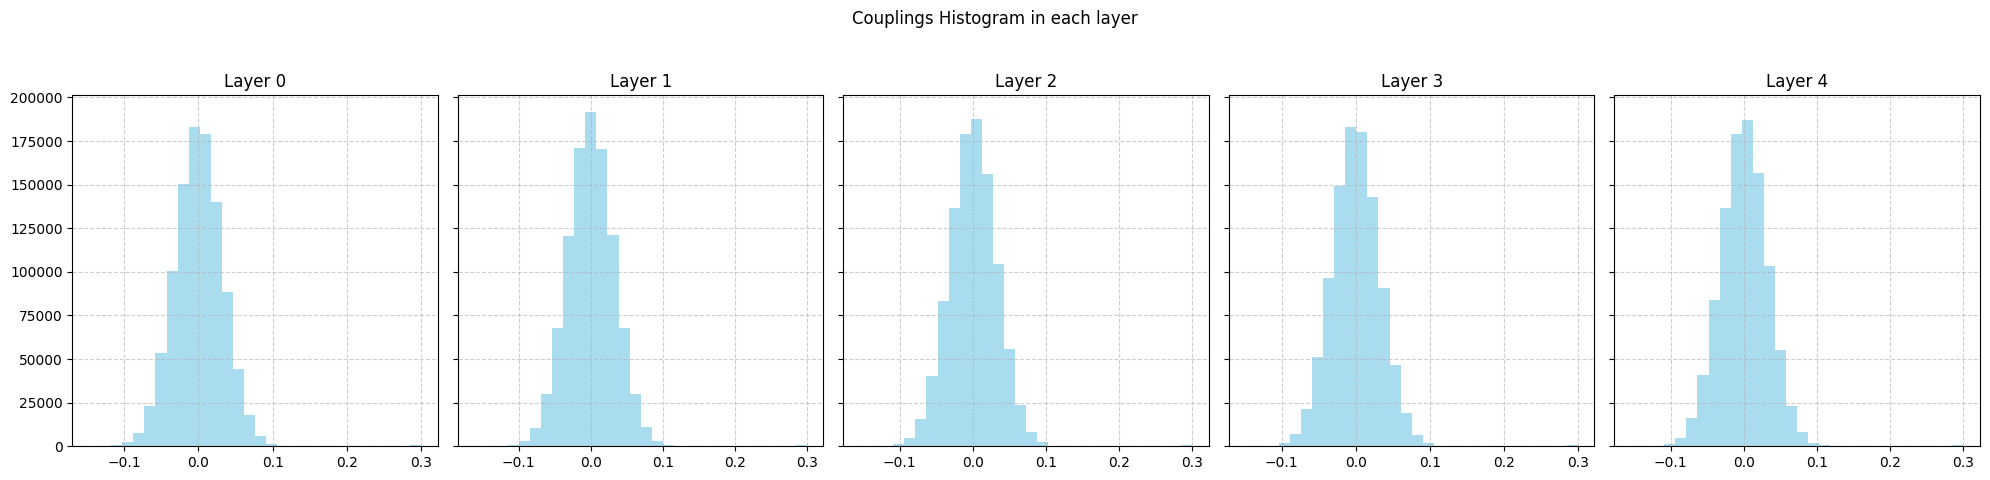

In [55]:
print_couplings_stats(model.ensemble)
plot_couplings_histogram(model.ensemble)
plt.show()

In [56]:
# Hyperparameters

initial_guess = np.sign(np.random.randn(N)).astype(int)
label_step_interval = 1
learning_steps = 1
lr = 0.02

  7%|▋         | 67000/1000000 [00:04<01:06, 14094.71it/s]


Inference has converged: True
Similarity of prediction to target: 0.5
Similarity of prediction to initial guess: 0.724

Coupling matrices (stats per layer):
Means: [0.0, 0.0, 0.0, 0.0, 0.0]
Stds: [0.033, 0.033, 0.033, 0.033, 0.033]


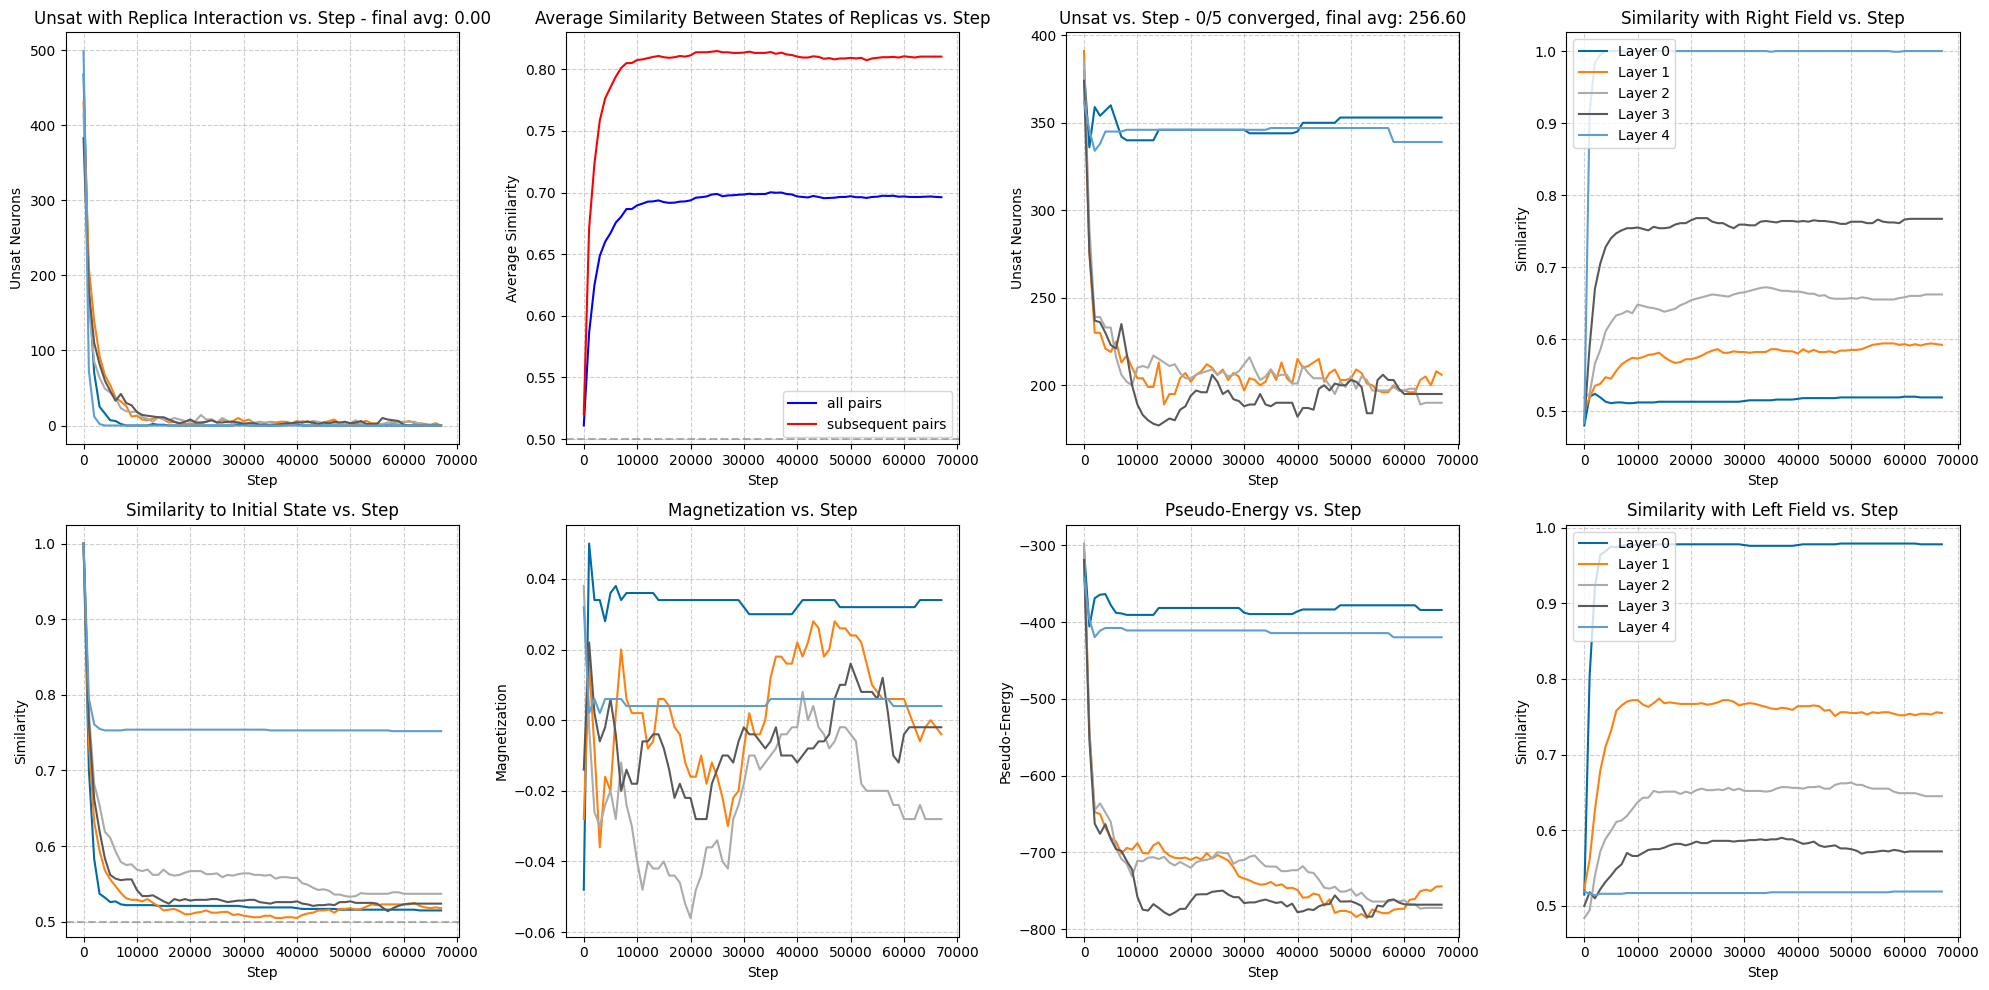

In [57]:
p0, converged = model.predict(
    input,
    max_steps,
    rng,
    label_step_interval=label_step_interval,
    initial_guess=initial_guess,
)
b0 = copy.deepcopy(model.ensemble)
print(f"Inference has converged: {converged}")
print(f"Similarity of prediction to target: {(p0 == label).sum() / N}")
print(f"Similarity of prediction to initial guess: {(p0 == initial_guess).sum() / N}")

print()
plot_dynamics_and_coupling_stats(model)
model.reset_state_and_loggers()

 11%|█         | 111000/1000000 [00:07<01:00, 14608.05it/s]


Results of first relaxation:

Coupling matrices (stats per layer):
Means: [0.0, 0.0, 0.0, 0.0, 0.0]
Stds: [0.039, 0.039, 0.039, 0.039, 0.039]


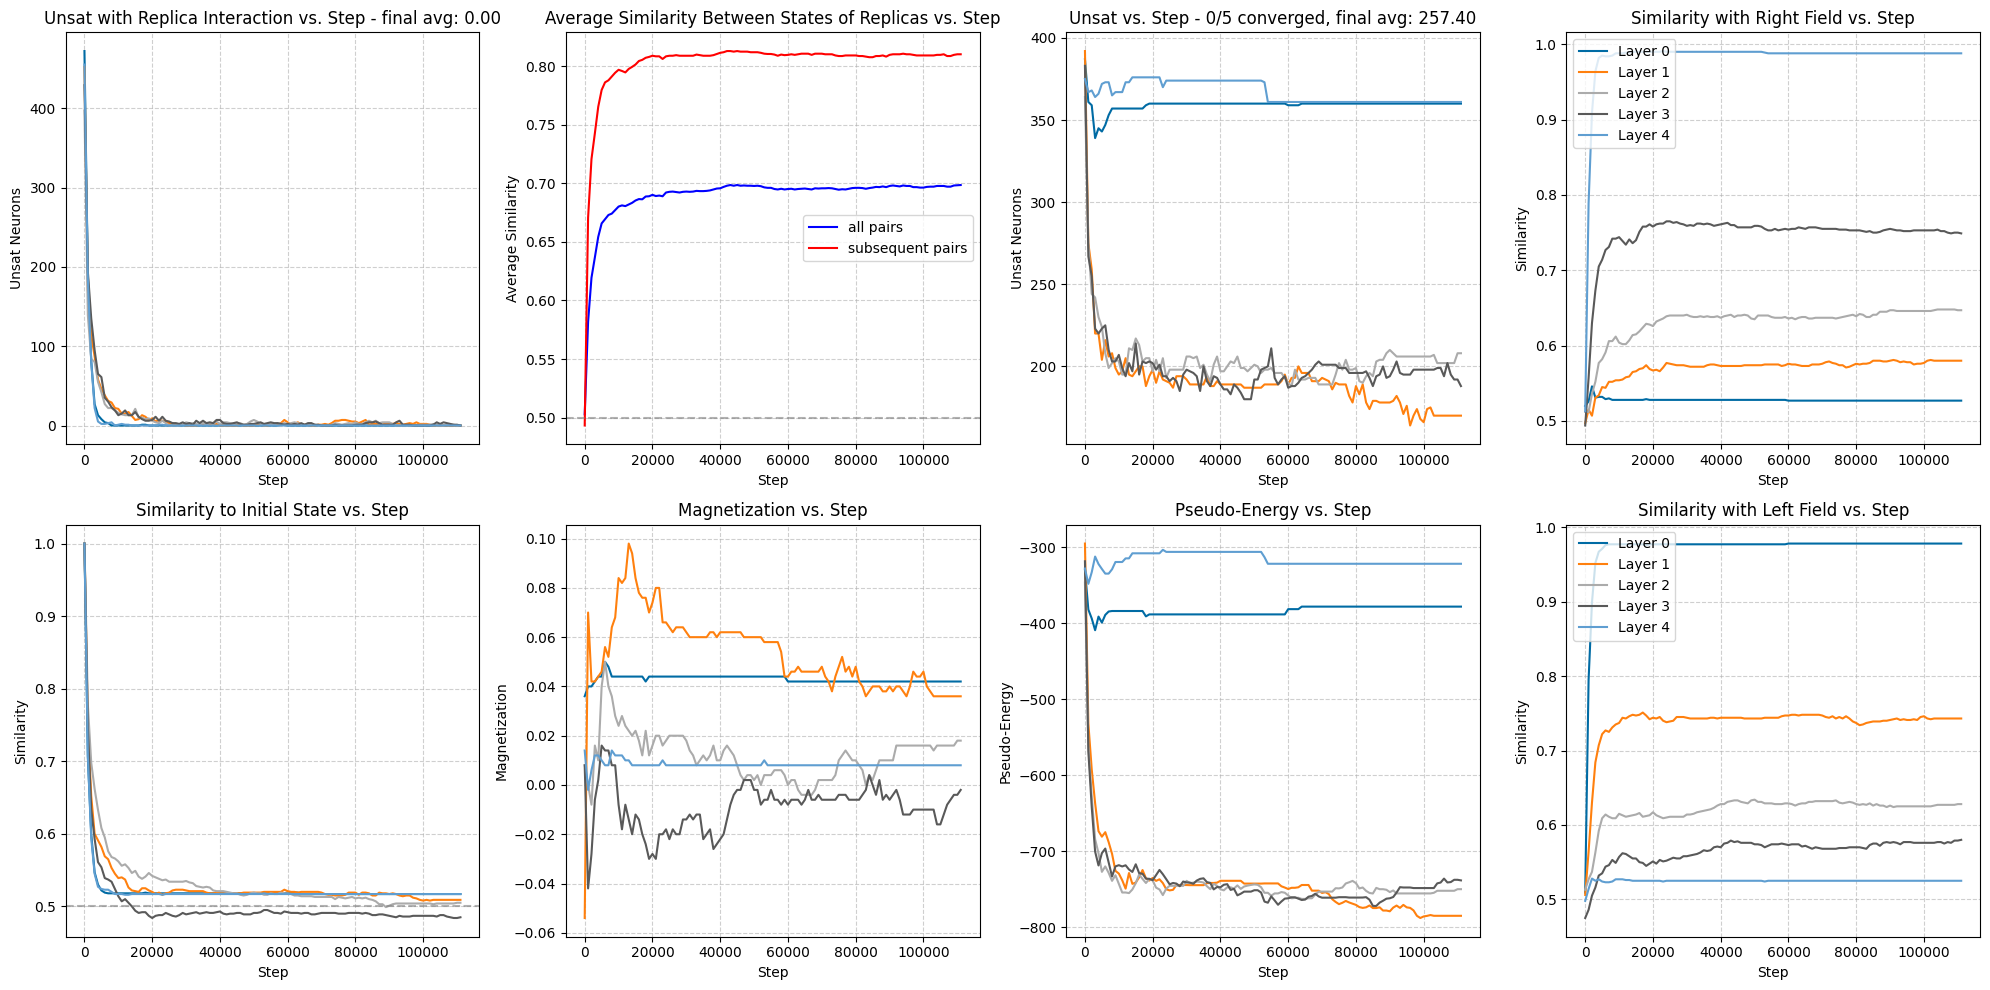

In [58]:
for i in range(learning_steps):
    model.train_step_hebb(input, label, lr, max_steps, rng)
    b1 = copy.deepcopy(model.ensemble)
    if i in [0, learning_steps - 1]:
        print(f"Results of {'first' if i == 0 else 'last'} relaxation:\n")
        plot_dynamics_and_coupling_stats(model)
    model.reset_state_and_loggers()

  1%|          | 9000/1000000 [00:00<01:09, 14300.68it/s]


Inference has converged: True
Similarity to target: 0.988
Similarity to initial guess: 0.504

Coupling matrices (stats per layer):
Means: [0.0, 0.0, 0.0, 0.0, 0.0]
Stds: [0.039, 0.039, 0.039, 0.039, 0.039]


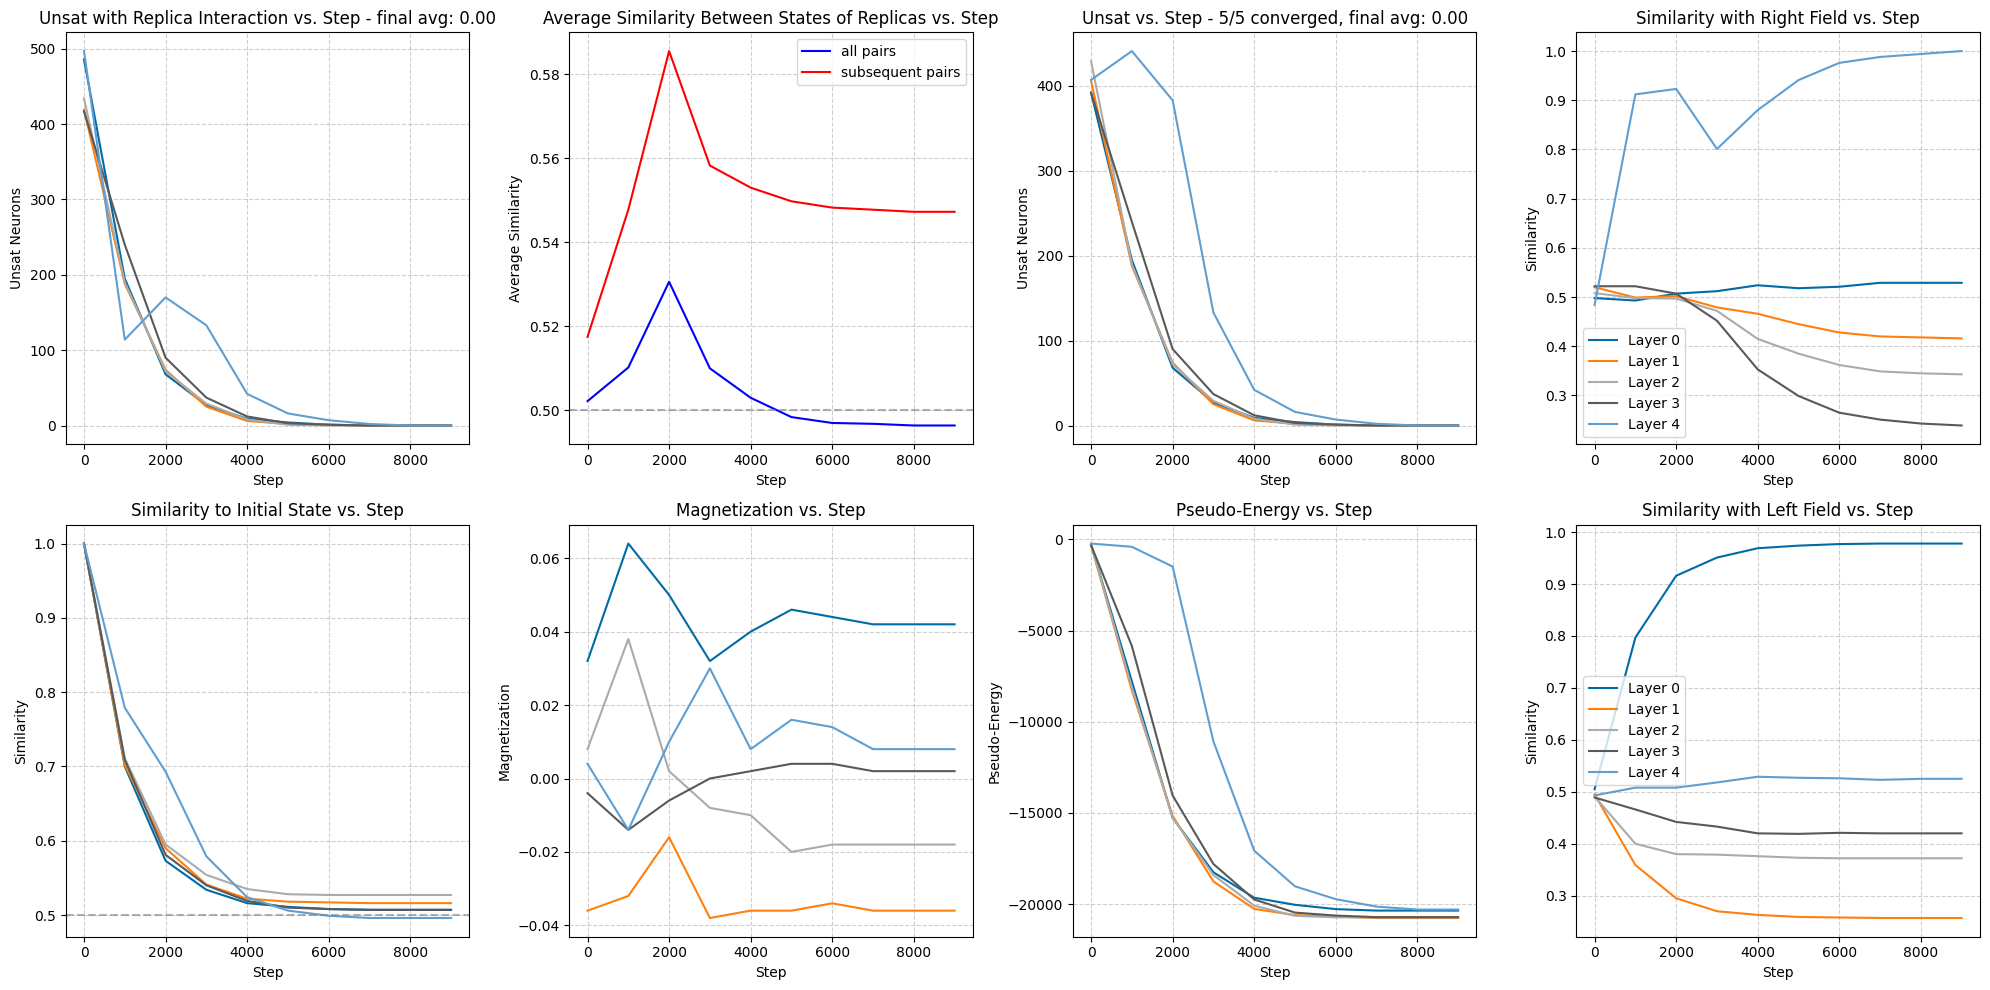

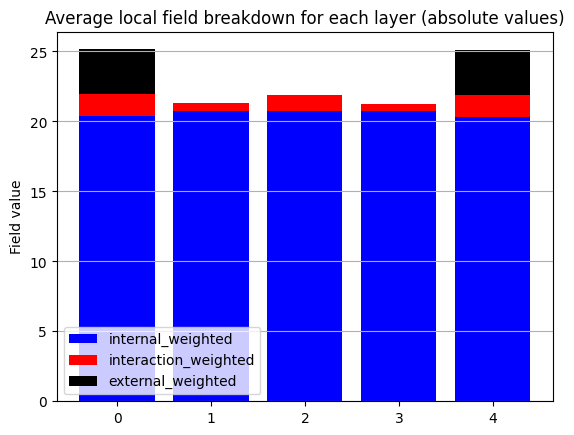

In [59]:
from src.multi_net.plotting import plot_field_breakdowns
from src.network.ensemble import collect_field_breakdowns

p2, converged = model.predict(
    input,
    1000000,
    rng,
    label_step_interval=label_step_interval,
    initial_guess=initial_guess,
)
b2 = copy.deepcopy(model.ensemble)

print(f"Inference has converged: {converged}")
print(f"Similarity to target: {(p2 == label).sum() / N}")
print(f"Similarity to initial guess: {(p2 == initial_guess).sum() / N}")
print()

plot_dynamics_and_coupling_stats(model)
breakdown = collect_field_breakdowns(model.ensemble, n=-1)
plot_field_breakdowns(breakdown, weighted=True)
plt.show()

model.reset_state_and_loggers()

In [60]:
print(f"Similarity between untrained prediction and label: {(p0 == label).mean():.2f}")
print(f"Similarity between trained prediction and label: {(p2 == label).mean():.2f}")
print(
    f"Similarity between untrained prediction and initial condition of inference: {(p0 == initial_guess).mean():.2f}"
)
print(
    f"Similarity between trained prediction and initial condition of inference: {(p2 == initial_guess).mean():.2f}"
)

Similarity between untrained prediction and label: 0.50
Similarity between trained prediction and label: 0.99
Similarity between untrained prediction and initial condition of inference: 0.72
Similarity between trained prediction and initial condition of inference: 0.50


In [61]:
print("Similarity between untrained and trained internal representations (layer-wise):")
print(
    [f"{b0.networks[i].state_similarity(b2.networks[i].state):.2f}" for i in range(y)]
)

Similarity between untrained and trained internal representations (layer-wise):
['0.98', '0.33', '0.43', '0.49', '0.50']


In [62]:
print(
    "Similarity between trained representations and the representations used for the last hebbian step:"
)
print(
    [f"{b2.networks[i].state_similarity(b1.networks[i].state):.2f}" for i in range(y)]
)

Similarity between trained representations and the representations used for the last hebbian step:
['1.00', '0.00', '0.00', '0.00', '1.00']
